In [1]:
## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()


import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torch.optim as optim
import os
import random
import pickle
import torchvision
import shutil
from torchvision import transforms
from tqdm import tqdm

C:\Users\PC\AppData\Local\Temp\ipykernel_4268\2949133806.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
torch.cuda.set_device(0)
device = torch.device("cuda")

def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_all_seeds(42)

# Read data

## Create val folder

In [5]:
def check_classes_amounts(path):
    classes = os.listdir(path)
    num_all = 0
    num_class = []
    for i in range(len(classes)):
        num_of_class = len(os.listdir(f"{path}/{classes[i]}"))
        num_class.append(num_of_class)
        num_all += num_of_class
    print(f"Number of all examples: {num_all}\nNumbers of every class: {num_class}")
    # return num_all, num_class

In [6]:
check_classes_amounts("./trafic_32")

Number of all examples: 39209
Numbers of every class: [210, 2220, 2250, 1410, 1980, 1860, 420, 1440, 1410, 1470, 2010, 1320, 2100, 2160, 780, 630, 420, 1110, 1200, 210, 360, 330, 390, 510, 270, 1500, 600, 240, 540, 270, 450, 780, 240, 689, 420, 1200, 390, 210, 2070, 300, 360, 240, 240]


In [7]:
def create_val_folder():
    sub_folders = os.listdir("./trafic_32")
    os.mkdir("./val_trafic_32")
    for sub_folder in sub_folders:
        os.mkdir(f"./val_trafic_32/{sub_folder}")

    for sub_folder in sub_folders:
        images_list = os.listdir(f"./trafic_32/{sub_folder}")
        to_move = random.sample(images_list, k=(len(images_list) // 5))
        for image in to_move:
            shutil.move(f"./trafic_32/{sub_folder}/{image}", f"./val_trafic_32/{sub_folder}/{image}")


In [11]:
# create_val_folder()

In [12]:
check_classes_amounts("./trafic_32")

Number of all examples: 31368
Numbers of every class: [168, 1776, 1800, 1128, 1584, 1488, 336, 1152, 1128, 1176, 1608, 1056, 1680, 1728, 624, 504, 336, 888, 960, 168, 288, 264, 312, 408, 216, 1200, 480, 192, 432, 216, 360, 624, 192, 552, 336, 960, 312, 168, 1656, 240, 288, 192, 192]


In [13]:
check_classes_amounts("./val_trafic_32")

Number of all examples: 7841
Numbers of every class: [42, 444, 450, 282, 396, 372, 84, 288, 282, 294, 402, 264, 420, 432, 156, 126, 84, 222, 240, 42, 72, 66, 78, 102, 54, 300, 120, 48, 108, 54, 90, 156, 48, 137, 84, 240, 78, 42, 414, 60, 72, 48, 48]


## Data preparation

In [14]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.ImageFolder("trafic_32/", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)


val_dataset = datasets.ImageFolder("val_trafic_32/", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

In [10]:
# does not work after transfation from image format to tensor
# from IPython.display import display
#
# image_num = 31367
# scale = 4
# display(train_dataset[image_num][0].resize(( int(train_dataset[image_num][0].width * scale), int(train_dataset[image_num][0].height * scale))))

# Net preparation

In [15]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self.fc_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = torch.flatten(x, 1)
        x       = self.LeakyReLU(self.fc_1(x))
        x       = self.LeakyReLU(self.fc_2(x))
        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)

        return mean, log_var

In [16]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        # x_hat = x_hat.view([-1, 1, 28, 28])
        x_hat = x_hat.view([-1, 3, 32, 32])
        return x_hat


In [17]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)


    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)        # sampling epsilon
        z = mean + var * epsilon
        return z


    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [18]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [19]:
vae = VAE(latent_dim=256, hidden_dim=1024, x_dim=3072).to(device)

In [20]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [21]:
num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in tqdm(iter(train_loader)):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var)
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()
    L1_list = []
    if n == 0 or n == 29:
        for x, _ in iter(val_loader):
            x  = x.to(device)
            out, _, _ = vae(x)
            L1_list.append(torch.mean(torch.abs(out-x)).item())
        print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

100%|██████████| 122/122 [00:29<00:00,  4.15it/s]


Epoch 0 loss 36101.90586577869, test L1 = 0.12843760679806432


100%|██████████| 122/122 [00:07<00:00, 17.40it/s]


Epoch 29 loss 13171.536044761782, test L1 = 0.07514837011694908


In [22]:
def get_train_images(start, num):
    return torch.stack([val_dataset[i][0] for i in range(start,start+num)], dim=0)

In [23]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

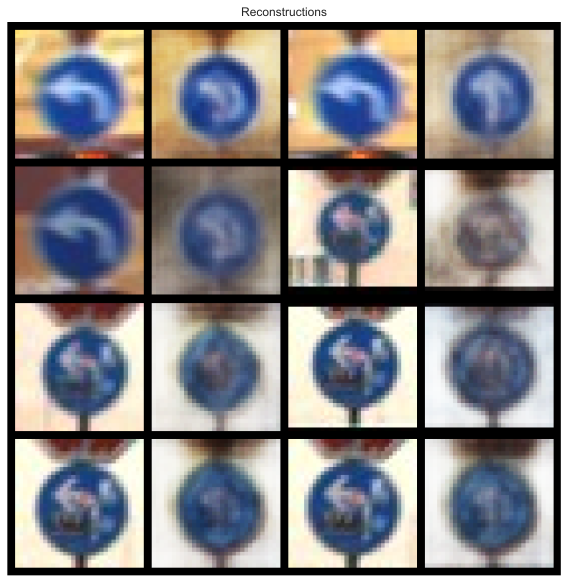

In [24]:
input_imgs = get_train_images(6765, 8)
visualize_reconstructions(vae, input_imgs, device)

In [25]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()

    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

C:\Users\przek\Desktop\VI sem\SSNE\laby_ssne\lib\site-packages\torchvision\utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


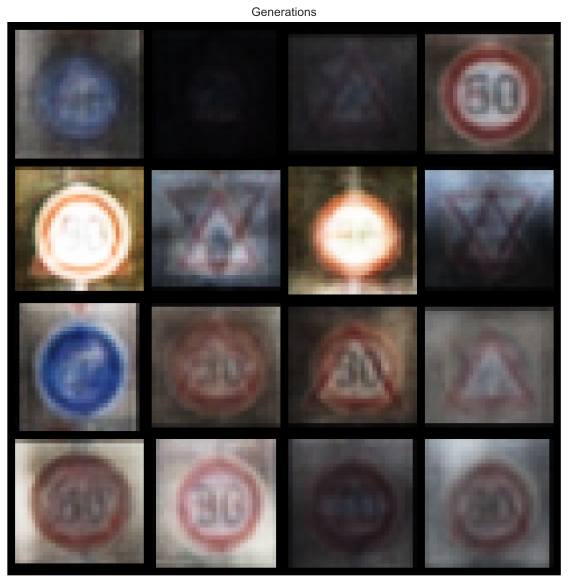

In [86]:
generate_images(vae, 16 , device)